# AST 4930 Week 6

## Permutation importance

### Let's load and split the Iris dataset.

In [1]:
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Let's find the best SVM model.

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Remember that we need feature scaling for SVM.
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('SVM', SVC(kernel='rbf'))
])

# Choose hyperparameters to optimize.
param_grid = {'SVM__C': [0.01, 0.1, 1., 10., 100.],
              'SVM__gamma': [0.01, 0.1, 1., 10., 100.]}

## grid search using cross validation
grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))
print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'SVM__C': 1.0, 'SVM__gamma': 0.1}
Best model: Pipeline(steps=[('scaler', StandardScaler()), ('SVM', SVC(gamma=0.1))])
Test score: 0.97


### We can also optimize SVM kernels using GridSearchCV, with the expense of potential redundant searches.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Remember that we need feature scaling for SVM.
## Didn't fix kernel to rbf
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('SVM', SVC())
])

# Choose hyperparameters to optimize.
## this time looking at kernel to vary b/t poly and rbf
## poly has degree parameter that it needs added, rbf doesn't care about degree so won;t use it 
## some experiments will be redundent b/c some values don;t use certian parameters
param_grid = {'SVM__kernel':['poly', 'rbf'],
              'SVM__C': [0.01, 0.1, 1., 10., 100.],
              'SVM__gamma': [0.01, 0.1, 1., 10., 100.],
              'SVM__degree': [1, 2, 4, 8]}

grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))
print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters: {'SVM__C': 0.01, 'SVM__degree': 1, 'SVM__gamma': 100.0, 'SVM__kernel': 'poly'}
Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('SVM', SVC(C=0.01, degree=1, gamma=100.0, kernel='poly'))])
Test score: 0.97


In [4]:
help(SVC)

Help on class SVC in module sklearn.svm._classes:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`~sklearn.svm.LinearSVC` or
 |  :class:`~sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`~sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 

### Let's compute the permutation importance.

In [5]:
# We first fit our best model.

## put one b/c in gridsearch we had scalar b/c need scaling for SVM
model = grid_search.best_estimator_[1]
model.fit(X_train, y_train) ## training

# We then compute the permutation importance using the test data.
from sklearn.inspection import permutation_importance

## give model you'll test, test data set, compute permutation importance using test data set
## might need to scale training data before fitting (doesn't need feature scaling for this data, but in future)
## repeats 10 times
r = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

### Let's print out what's in the output.

In [6]:
## result r will give all imp for first feature, will give 10 numbers for each feature
## four features
## mean avg score for avg importance for each feature
r

{'importances_mean': array([0.07368421, 0.01315789, 0.54210526, 0.14210526]),
 'importances_std': array([0.02834297, 0.01765317, 0.04880852, 0.0590788 ]),
 'importances': array([[ 0.07894737,  0.07894737,  0.10526316,  0.05263158,  0.05263158,
          0.07894737,  0.02631579,  0.07894737,  0.13157895,  0.05263158],
        [ 0.02631579,  0.02631579,  0.        ,  0.02631579,  0.02631579,
          0.        ,  0.02631579,  0.02631579, -0.02631579,  0.        ],
        [ 0.55263158,  0.60526316,  0.52631579,  0.57894737,  0.44736842,
          0.60526316,  0.55263158,  0.55263158,  0.52631579,  0.47368421],
        [ 0.23684211,  0.23684211,  0.15789474,  0.05263158,  0.13157895,
          0.15789474,  0.07894737,  0.13157895,  0.07894737,  0.15789474]])}

### Let's make a feature importance plot.

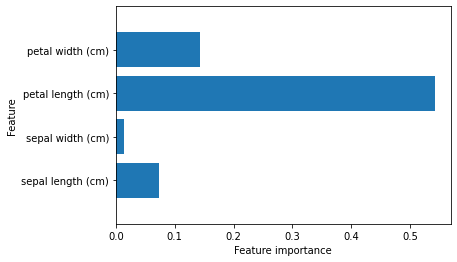

In [7]:
## bar plot forr output
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(np.arange(n_features), r.importances_mean, align='center')
    plt.yticks(np.arange(n_features), iris.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(r)

If we mess up petal length score will decreas around 50% - most important feature

### We can also make a box plot.

Text(0, 0.5, 'Feature')

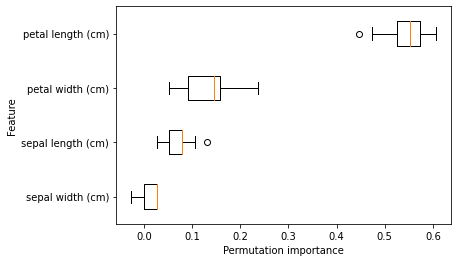

In [8]:
sorted_idx = r.importances_mean.argsort()

fig, ax = plt.subplots()

ax.boxplot(r.importances[sorted_idx].T,
           vert=False, labels=np.array(iris.feature_names)[sorted_idx])

ax.set_xlabel("Permutation importance")
ax.set_ylabel("Feature")


 yellow bar shows median
 shows 1st or 3rd quartile (?)
 here we see some importances have negative values. Score improves when feature is removed

### Permutation importance with correlated features

#### The following example from sklearn uses Random Forest, which we haven learned yet. So don't worry about what it does for now.

In [9]:
#From https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

## what happens to perm import w/ correlated features?

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier

data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42) ## only difference, we use rand forest as opposed to knn or SVM
model.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(model.score(X_test, y_test)))

Accuracy on test data: 0.97


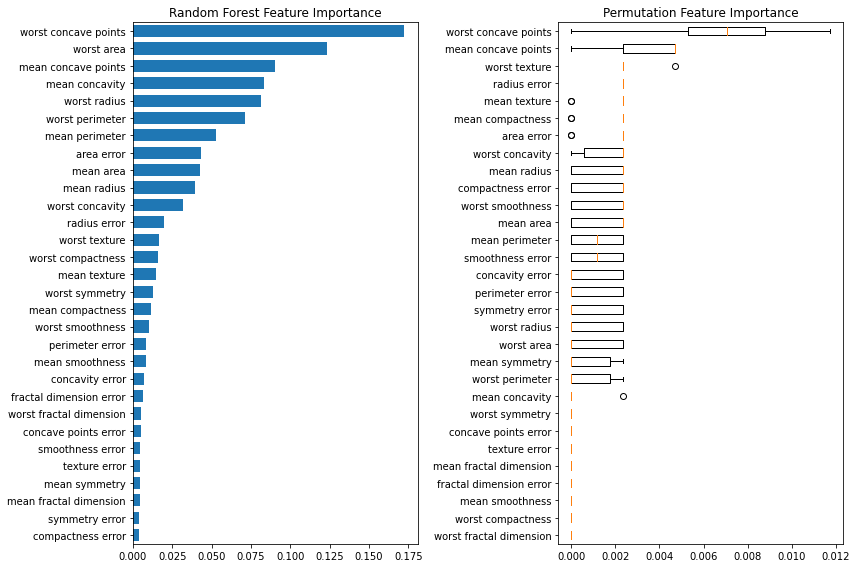

In [10]:
# This is the impurity-based feature importance from Random Forest

## random forest - multiple decision trees
tree_importance_sorted_idx = np.argsort(model.feature_importances_)
tree_indices = np.arange(0, len(model.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.barh(tree_indices,
         model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(model.feature_importances_)))
ax1.set_title('Random Forest Feature Importance')

# This is the permutation feature importance

r = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = r.importances_mean.argsort()

ax2.boxplot(r.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
ax2.set_title('Permutation Feature Importance')

fig.tight_layout()
plt.show()

Left shows feature importance rand forest gives. When looking at permutation importance, looks like none are very important

We get 97% accuracy and even if we drop most imp features, accuracy only drops around 1%

So maybe mean concave points, worst area, worst radius, worst param, all related

If you remove one, you can still use the others since they're related

In these cases permutation importance may not work

### TODO: Using the breast cancer data, find the best SVM model and compute the permutation feature importance. How does that compare with Random Forest feature importance?

In [11]:
data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Remember that we need feature scaling for SVM.
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('SVM', SVC(kernel='rbf'))
])

# Choose hyperparameters to optimize.
param_grid = {'SVM__C': [0.01, 1.0, 10., 100, 1000],
              'SVM__gamma': [0.00001, 0.0001, 0.001, 0.01, 0.01]}

## grid search using cross validation
grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best model: {}".format(grid_search.best_estimator_))
print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'SVM__C': 1000, 'SVM__gamma': 0.0001}
Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('SVM', SVC(C=1000, gamma=0.0001))])
Test score: 0.97


### TODO: make a heatmap

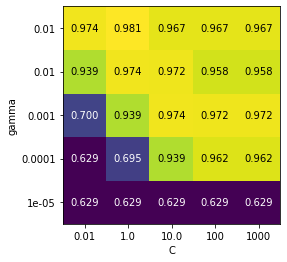

In [12]:
## heatmap
import pandas as pd
import numpy as np
import mglearn

results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(5,5)

mglearn.tools.heatmap(scores, xlabel='C', xticklabels=param_grid['SVM__C'],
                     ylabel='gamma', yticklabels=param_grid['SVM__gamma'], cmap='viridis', fmt="%.3f")


### TODO: make a confusion matrix

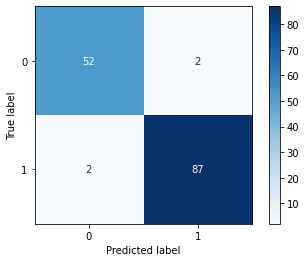

In [13]:
## confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(grid_search.predict(X_test), y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


### TODO: Compute the permutation importance.

In [14]:
# We first fit our best model.

X_train_scaled = StandardScaler().fit(X_train).transform(X_train)
X_test_scaled = StandardScaler().fit(X_test).transform(X_test)

model = SVC(kernel='rbf', C=grid_search.best_params_['SVM__C'],
           gamma=grid_search.best_params_['SVM__gamma'])
#model = grid_search.best_estimator_[1]
model.fit(X_train_scaled, y_train)

# We then compute the permutation importance using the test data.
from sklearn.inspection import permutation_importance

r = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=0)

In [15]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('SVM', SVC(C=1000, gamma=0.0001))])

### TODO: Make a plot showing permutation importance.

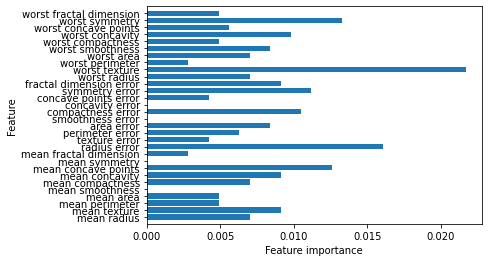

In [16]:
## bar plot forr output
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(np.arange(n_features), r.importances_mean, align='center')
    plt.yticks(np.arange(n_features), data.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(r)

Text(0, 0.5, 'Feature')

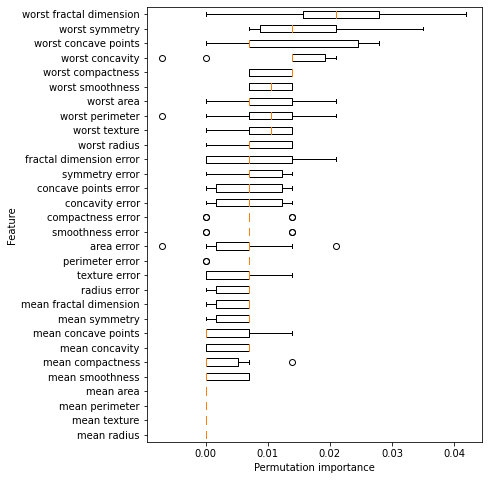

In [17]:
# box plot

fig, ax = plt.subplots(figsize=(6,8))

perm_sorted_idx = r.importances_mean.argsort()

ax.boxplot(r.importances[perm_sorted_idx].T,
           vert=False, labels=np.array(data.feature_names))

ax.set_xlabel("Permutation importance")
ax.set_ylabel("Feature")
